In [69]:
from tensorflow import keras
from keras import layers
from random import randint
import keras_tuner as kt

# Prepare the dataset

In [105]:
def prepare_datasets():
    train_ds, test_ds = keras.utils.image_dataset_from_directory(
        directory='../data/pngimages',
        labels='inferred', # Labels are sorted alphanumerically, so 10 comes before 2
        subset='both',
        seed=randint(0, 2**32),
        validation_split=0.2,
        image_size=(128, 128),
        color_mode='rgb',
    )

    reduced_train_ds, val_ds = keras.utils.split_dataset(train_ds, 0.75, shuffle=True) # 0.25 * 0.8 = 0.2, so size of val ds = size of test ds
    return reduced_train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = prepare_datasets()

Found 1125 files belonging to 15 classes.
Using 900 files for training.
Using 225 files for validation.


In [106]:
## Preferably put this in a different module..
def build_model(hp):
    model = keras.Sequential([
        layers.Resizing(128, 128), # This is already handled by the loader
        layers.RandomFlip('horizontal'),
        layers.Rescaling(1 / 255),
        layers.Conv2D(16, 3, input_shape=(128, 128, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(hp.get('fc_neurons'), activation='relu'),
        layers.Dropout(hp.get('dropout_rate')),
        layers.Dense(15, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

In [112]:
_PLANT_NAMES = [
    "Ulmus carpinifolia",  # 1
    "Sorbus aucuparia",  # 10
    "Salix sinerea",  # 11
    "Populus",  # 12
    "Tilia",  # 13
    "Sorbus intermedia",  # 14
    "Fagus silvatica",  # 15
    "Acer",  # 2
    "Salix aurita",  # 3
    "Quercus",  # 4
    "Alnus incana",  # 5
    "Betula pubescens",  # 6
    "Salix alba 'Sericea'",  # 7
    "Populus tremula",  # 8
    "Ulmus glabra"  # 9
]


# Hyperparameter tuning and model training

In [109]:
hp = kt.HyperParameters()
hp.Choice(name='dropout_rate', values = [0.0, 0.1,0.2])
hp.Choice(name='learning_rate', values=[0.001])
hp.Choice(name='fc_neurons', values=[64, 128, 256])

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    hyperparameters=hp,
)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner.search(train_ds, epochs=100, validation_data=val_ds, callbacks=[callback])

tuner.results_summary()

Trial 9 Complete [00h 01m 18s]
val_loss: 0.28815758228302

Best val_loss So Far: 0.21863767504692078
Total elapsed time: 00h 20m 32s
Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 00 summary
Hyperparameters:
dropout_rate: 0.1
learning_rate: 0.001
fc_neurons: 256
Score: 0.21863767504692078

Trial 04 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.001
fc_neurons: 256
Score: 0.25439584255218506

Trial 05 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.001
fc_neurons: 256
Score: 0.25862741470336914

Trial 02 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.001
fc_neurons: 128
Score: 0.28714555501937866

Trial 08 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.001
fc_neurons: 128
Score: 0.28815758228302

Trial 01 summary
Hyperparameters:
dropout_rate: 0.1
learning_rate: 0.001
fc_neurons: 128
Score: 0.3990013003349304

Trial 07 summary
Hyperparameters:
dropout_rate: 0.2
lea

In [110]:
best_model = tuner.get_best_models(num_models=1)[0]

best_model.evaluate(test_ds)

8/8 [==============================] - 2s 240ms/step - loss: 0.2609 - accuracy: 0.9244


[0.260883629322052, 0.9244444370269775]

1/1 [==============================] - 0s 32ms/step


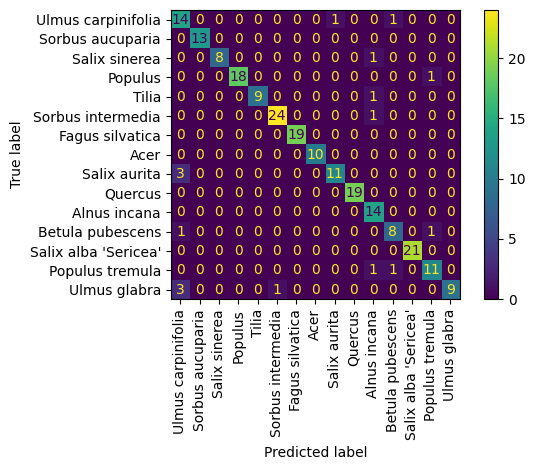

<Figure size 640x480 with 0 Axes>

In [133]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np



all_predictions = []
true_labels = []

# Iterate over the test dataset to make predictions
for images, labels in test_ds:
    # Make predictions for the batch of images
    predictions = best_model.predict(images)
    
    # Convert predictions to class labels
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Append predictions and true labels to the lists
    all_predictions.extend(predicted_labels)
    true_labels.extend(labels.numpy())

cm = confusion_matrix(true_labels, all_predictions)
cm = ConfusionMatrixDisplay(cm, display_labels=_PLANT_NAMES)
cm.plot(xticks_rotation=90)
plt.tight_layout()
plt.show()
plt.savefig('confusion.png')